In [1]:
# import the relevant packages and dataset
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets


In [2]:
# device agnostic check
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_folder = "~/data/FMNIST"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [4]:
# build a class that fetches the dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        x = x.float()
        x = x.view(-1, 28*28) # flatten it to 784 numeric values
        self.x, self.y = x, y
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [5]:
# Create a function that generates a training DataLoader from the dataset
def get_data():
    train = MyDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [6]:
# Define a model, loss function and optimizer
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer

In [7]:
# define the function that will train the dataset on a batch of images
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    predictions = model(x)
    #compute loss
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward()
    optimizer = SGD(model.parameters(), lr=0.01)
    optimizer.step()
    # flush gradients memory for next batch of calculation
    optimizer.zero_grad()
    return batch_loss.item()

In [8]:
# build a function that calculates the accuracy of a given dataset
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.tolist()

In [9]:
# train the neural network
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [10]:
# lists for accuracies and losses
losses, accuracies = [], []

In [11]:
# Define the number of epoch
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    # Create batches of training data by iterating through the DataLoader
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        # train the batch using the train_batch()
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    # Calculate the accuracy of prediction at the end of training on all batches
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.array(epoch_accuracies).mean()
    # store the loss and accuracy values at the end of each epoch in a list
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
            


0
1
2
3
4


/var/folders/y5/5kc5fqvn2tncnl_868zg4zhr0000gn/T/ipykernel_94235/1669072497.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


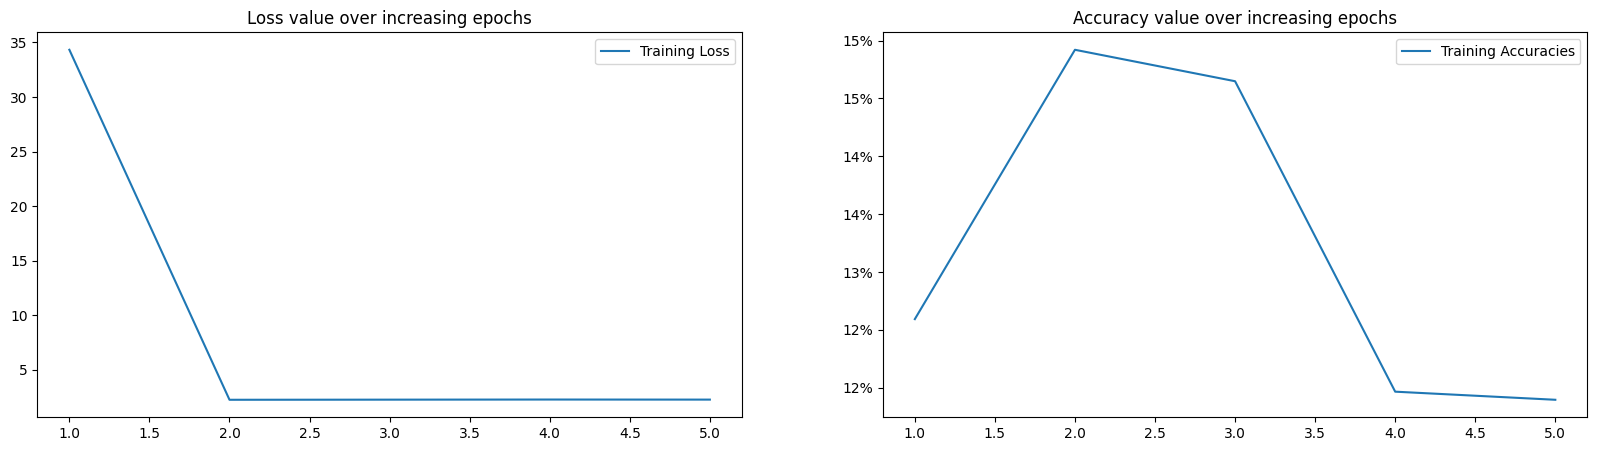

In [13]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Loss value over increasing epochs")
plt.plot(epochs, losses, label="Training Loss")
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="Training Accuracies")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()